In [1]:
import pandas as pd
import os

# About the data

We get the data from the [NYTK-NerKor](https://github.com/nytud/NYTK-NerKor) repo. It contains 1 million tokens.

# Downloading the data

In [2]:
!rm -rf  temp
!git clone https://github.com/nytud/NYTK-NerKor.git temp
!cp -R ./temp/data ./data
!rm -rf  temp

Cloning into 'temp'...
remote: Enumerating objects: 2026, done.
remote: Counting objects: 100% (515/515), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 2026 (delta 508), reused 493 (delta 493), pack-reused 1511
Receiving objects: 100% (2026/2026), 6.26 MiB | 7.46 MiB/s, done.
Resolving deltas: 100% (868/868), done.


# Preparing and exploring the data

## Get the columns of the data

In [3]:
def get_columns(file_path):
    with open(file_path, "r") as rf:
        with open(os.path.join(file_path)) as f:
            column_line = f.readline()
            columns = column_line.split("=")[1]
            columns = [c.strip() for c in columns.split(" ") if c]
            return columns


In [4]:
get_columns("./data/train-devel-test/train/fiction/no-morph/chilcote_12.conllup")

['FORM', 'LEMMA', 'UPOS', 'XPOS', 'FEATS', 'CONLL:NER']

## Loading the data into a pandas DataFrame

In [5]:
def load_conllup_file(file_path):
    conllu_columns = get_columns("./data/train-devel-test/train/fiction/no-morph/chilcote_12.conllup")
    df = pd.DataFrame(columns=["sentence_index", "position_number_in_sentence", *conllu_columns])
    with open(file_path, encoding="UTF-8") as f:
        sentence_index = 0
        position_number_in_sentence = 0
        line = f.readline() # skip the first comment line
        line = f.readline()
        while line:
            if line == "\n":
                sentence_index +=  1
                position_number_in_sentence = 0
            else:
                splitted_line = line.split()
                conllu_row_part = {}
                for i in range(len(conllu_columns)):
                    conllu_row_part[f"{conllu_columns[i]}"] = splitted_line[i]
                
                row = {
                    "sentence_index": sentence_index,
                    "position_number_in_sentence": position_number_in_sentence,
                    **conllu_row_part
                }
                row = pd.Series(row)
                df.loc[len(df)] = row
                position_number_in_sentence += 1
            line = f.readline()
        return df

### Test the loading

In [6]:
df = load_conllup_file("./data/train-devel-test/train/fiction/no-morph/chilcote_12.conllup")

In [7]:
df.head(5)

,sentence_index,position_number_in_sentence,FORM,LEMMA,UPOS,XPOS,FEATS,CONLL:NER
0,0,0,-,_,_,_,_,O
1,0,1,Korán,_,_,_,_,O
2,0,2,ebédelnek,_,_,_,_,O
3,0,3,",",_,_,_,_,O
4,0,4,úgy,_,_,_,_,O


In [8]:
df["CONLL:NER"].value_counts()

O         3637
B-PER       50
B-LOC       21
I-LOC       14
B-MISC       1
Name: CONLL:NER, dtype: int64

# Converting conllup data to csv format


I convert the data to csv format, because it makes it faster to load the data into pandas

In [9]:
train_test_devel_data_path = os.path.join("data", "train-devel-test")
train_test_devel_data_dirs = [os.path.join(train_test_devel_data_path, data_dir) for data_dir in os.listdir(train_test_devel_data_path) if os.path.isdir(os.path.join(train_test_devel_data_path, data_dir))]

## Get directories that contain data in the train-devel-test directory

In [10]:
def get_train_devel_test_conllup_file_dirs():
    train_devel_test_conllup_file_dirs = {}
    for d in train_test_devel_data_dirs:
        connlup_file_dirs = [os.path.join(d, genre_dir, "no-morph") for genre_dir in os.listdir(d) if os.path.isdir(os.path.join(d, genre_dir)) and "no-morph" in os.listdir(os.path.join(d, genre_dir))]
        train_devel_test_conllup_file_dirs[os.path.basename(d)] = connlup_file_dirs
    return train_devel_test_conllup_file_dirs

### Filter .conllup files

In [11]:
import re
connlup_file_pattern = re.compile(".*.conllup") 
def get_connlup_files_in_dir(path_to_dir):
    return [f for f in os.listdir(path_to_dir) if connlup_file_pattern.match(f)]

### Print the found directories

In [12]:
get_train_devel_test_conllup_file_dirs()

{'devel': ['data/train-devel-test/devel/legal/no-morph',
  'data/train-devel-test/devel/news/no-morph',
  'data/train-devel-test/devel/wikipedia/no-morph',
  'data/train-devel-test/devel/fiction/no-morph'],
 'test': ['data/train-devel-test/test/legal/no-morph',
  'data/train-devel-test/test/news/no-morph',
  'data/train-devel-test/test/wikipedia/no-morph',
  'data/train-devel-test/test/fiction/no-morph'],
 'train': ['data/train-devel-test/train/legal/no-morph',
  'data/train-devel-test/train/news/no-morph',
  'data/train-devel-test/train/wikipedia/no-morph',
  'data/train-devel-test/train/fiction/no-morph']}

### Test .conllup file filtering

In [13]:
train_devel_test_conllup_file_dirs = get_train_devel_test_conllup_file_dirs()
get_connlup_files_in_dir(train_devel_test_conllup_file_dirs["devel"][0])

['dgt_1.conllup', 'eesc_22.conllup', 'jrc_11.conllup', 'const_3.conllup']

### Loading conllup files in a directory into a combined DataFrame

In [14]:
def load_all_conllup_files_in_dir(path_to_dir, train_test_devel, genre, save_intermediate_dataframes_to_csv = False):
    conllup_file_paths = [os.path.join(path_to_dir, cf) for cf in get_connlup_files_in_dir(path_to_dir)]
    combined_df = pd.DataFrame()
    for conllup_file in conllup_file_paths:
        print(conllup_file)
        df = load_conllup_file(conllup_file)
        df["train_test_devel"] = train_test_devel # Add new 
        df["genre"] = genre
        df["file_path"] = conllup_file
        if save_intermediate_dataframes_to_csv:
          df.to_csv(conllup_file.replace(".conllup", ".csv"))
        combined_df = pd.concat([combined_df, df])
    return combined_df


### Test conllup file loading into a DataFrame

In [15]:
data = load_all_conllup_files_in_dir(train_devel_test_conllup_file_dirs["devel"][0], "devel",train_devel_test_conllup_file_dirs["devel"][0].split(os.path.sep)[-2])

data/train-devel-test/devel/legal/no-morph/dgt_1.conllup
data/train-devel-test/devel/legal/no-morph/eesc_22.conllup
data/train-devel-test/devel/legal/no-morph/jrc_11.conllup
data/train-devel-test/devel/legal/no-morph/const_3.conllup


As we can see even loading one folder can take ages, so it is better to convert to csv for faster loading.

## Getting word_counts and converting data to csv

In [16]:

word_counts = {}
for data_set in train_devel_test_conllup_file_dirs:
    word_counts[data_set] = {}
    for genre_dir in train_devel_test_conllup_file_dirs[data_set]:
        print(genre_dir)
        genre = genre_dir.split(os.path.sep)[-2]
        df = load_all_conllup_files_in_dir(genre_dir, data_set, genre, True)
        df.to_csv(os.path.join(genre_dir, f"{genre}_full.csv"))
        word_counts[data_set][genre] = {"word_count": len(df), "unique_words": len(df["FORM"].unique())}
print(word_counts)


data/train-devel-test/devel/legal/no-morph
data/train-devel-test/devel/legal/no-morph/dgt_1.conllup
data/train-devel-test/devel/legal/no-morph/eesc_22.conllup
data/train-devel-test/devel/legal/no-morph/jrc_11.conllup
data/train-devel-test/devel/legal/no-morph/const_3.conllup
data/train-devel-test/devel/news/no-morph
data/train-devel-test/devel/news/no-morph/globalvoices_1.conllup
data/train-devel-test/devel/news/no-morph/rapid_15.conllup
data/train-devel-test/devel/news/no-morph/globalvoices_11.conllup
data/train-devel-test/devel/news/no-morph/rapid_2.conllup
data/train-devel-test/devel/news/no-morph/newscrawl_1.conllup
data/train-devel-test/devel/wikipedia/no-morph
data/train-devel-test/devel/wikipedia/no-morph/huwiki_200_71.conllup
data/train-devel-test/devel/wikipedia/no-morph/huwiki_200_69.conllup
data/train-devel-test/devel/wikipedia/no-morph/huwiki_200_70.conllup
data/train-devel-test/devel/wikipedia/no-morph/huwiki_200_8.conllup
data/train-devel-test/devel/wikipedia/no-morph/huw

This took a lot of time, but now that we have the data in csv format, we are good to go.

### Saving the word_count result to a json file for later usage

In [17]:
import json
with open("word_count.json", "w") as f:
    json.dump(word_counts, f )

# Visualizing the data

## Loading the csv files from directories

In [18]:

def load_csv_files_from_dir(path_to_dir):
    csv_files = [os.path.join(path_to_dir,f) for f in os.listdir(path_to_dir) if f.find(".csv") != -1 and f.find("_full.csv") == -1]
    df = pd.DataFrame()
    for csv_file in csv_files:
        temp_df = pd.read_csv(csv_file, index_col=0)
        df = pd.concat([df, temp_df])
    return df

### Testing the csv file loading 

In [19]:
load_csv_files_from_dir(get_train_devel_test_conllup_file_dirs()["test"][0])

,sentence_index,position_number_in_sentence,FORM,LEMMA,UPOS,XPOS,FEATS,CONLL:NER,train_test_devel,genre,file_path
0,0,0,Ha,_,_,_,_,O,test,legal,data/train-devel-test/test/legal/no-morph/dgt_...
1,0,1,az,_,_,_,_,O,test,legal,data/train-devel-test/test/legal/no-morph/dgt_...
2,0,2,egység,_,_,_,_,O,test,legal,data/train-devel-test/test/legal/no-morph/dgt_...
3,0,3,egy,_,_,_,_,O,test,legal,data/train-devel-test/test/legal/no-morph/dgt_...
4,0,4,2004.,_,_,_,_,O,test,legal,data/train-devel-test/test/legal/no-morph/dgt_...
...,...,...,...,...,...,...,...,...,...,...,...
5780,201,28,amennyiben,_,_,_,_,O,test,legal,data/train-devel-test/test/legal/no-morph/cons...
5781,201,29,szükséges,_,_,_,_,O,test,legal,data/train-devel-test/test/legal/no-morph/cons...
5782,201,30,–,_,_,_,_,O,test,legal,data/train-devel-test/test/legal/no-morph/cons...
5783,201,31,kiigazítja,_,_,_,_,O,test,legal,data/train-devel-test/test/legal/no-morph/cons...


## Import libraries for visualizing

In [20]:
!python --version

Python 3.7.15


Update python code from: https://stackoverflow.com/questions/68657341/how-can-i-update-google-colabs-python-version

In [30]:
import matplotlib.pyplot as plt
import numpy as np

## Loading the result of the word counts job

In [31]:
import json
with open("word_count.json", "r") as f:
    word_count = json.load(f)
    print(word_count)

{'devel': {'legal': {'word_count': 22647, 'unique_words': 6858}, 'news': {'word_count': 19849, 'unique_words': 7726}, 'wikipedia': {'word_count': 20066, 'unique_words': 7724}, 'fiction': {'word_count': 20870, 'unique_words': 6294}}, 'test': {'legal': {'word_count': 22040, 'unique_words': 7041}, 'news': {'word_count': 20848, 'unique_words': 7838}, 'wikipedia': {'word_count': 19378, 'unique_words': 7704}, 'fiction': {'word_count': 20814, 'unique_words': 6425}}, 'train': {'legal': {'word_count': 158152, 'unique_words': 28352}, 'news': {'word_count': 163779, 'unique_words': 36976}, 'wikipedia': {'word_count': 154517, 'unique_words': 35972}, 'fiction': {'word_count': 161410, 'unique_words': 31070}}}


## Plot word counts

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


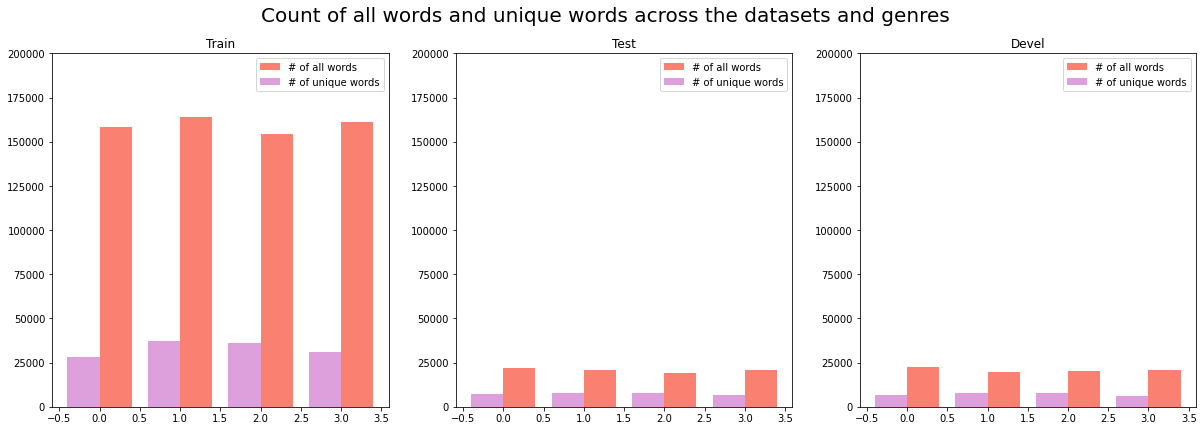

In [39]:
def plot_word_counts(word_counts):
    datasets = [dataset for dataset in word_counts]
    fig, ax = plt.subplots(1,len(datasets))
    fig.suptitle("Count of all words and unique words across the datasets and genres",  fontsize=20)
    fig.set_size_inches(20.5, 6.5)
    for i, dataset in enumerate(reversed(datasets)):
        genres = [genre for genre in word_counts[dataset]]
        width = 0.4
        x = np.arange(len(genres))
        y_values = {}
        for genre in genres:
            for word_count in word_counts[dataset][genre]:
                if word_count not in y_values:
                    y_values[word_count] = [word_counts[dataset][genre][word_count]]
                else:
                    y_values[word_count].append(word_counts[dataset][genre][word_count])
        for j, word_count in enumerate(y_values):
            label = "# of all words" if word_count == "word_count" else "# of unique words" 
            color = "salmon" if j == 0 else "plum"
            rects = ax[i].bar((x + (width/2 * (-1)**j)), y_values[word_count], width, label=label, color=color)
        ax[i].set_xticks(x, genres)
        ax[i].legend()
        ax[i].set_title(f"{dataset[0].upper()}{dataset[1:]}")
        ax[i].set_ylim(0, 200_000)
        

plot_word_counts(word_count)

## Plot distribution of labels across datasets and genres

{'devel': ['data/train-devel-test/devel/legal/no-morph', 'data/train-devel-test/devel/news/no-morph', 'data/train-devel-test/devel/wikipedia/no-morph', 'data/train-devel-test/devel/fiction/no-morph'], 'test': ['data/train-devel-test/test/legal/no-morph', 'data/train-devel-test/test/news/no-morph', 'data/train-devel-test/test/wikipedia/no-morph', 'data/train-devel-test/test/fiction/no-morph'], 'train': ['data/train-devel-test/train/legal/no-morph', 'data/train-devel-test/train/news/no-morph', 'data/train-devel-test/train/wikipedia/no-morph', 'data/train-devel-test/train/fiction/no-morph']}


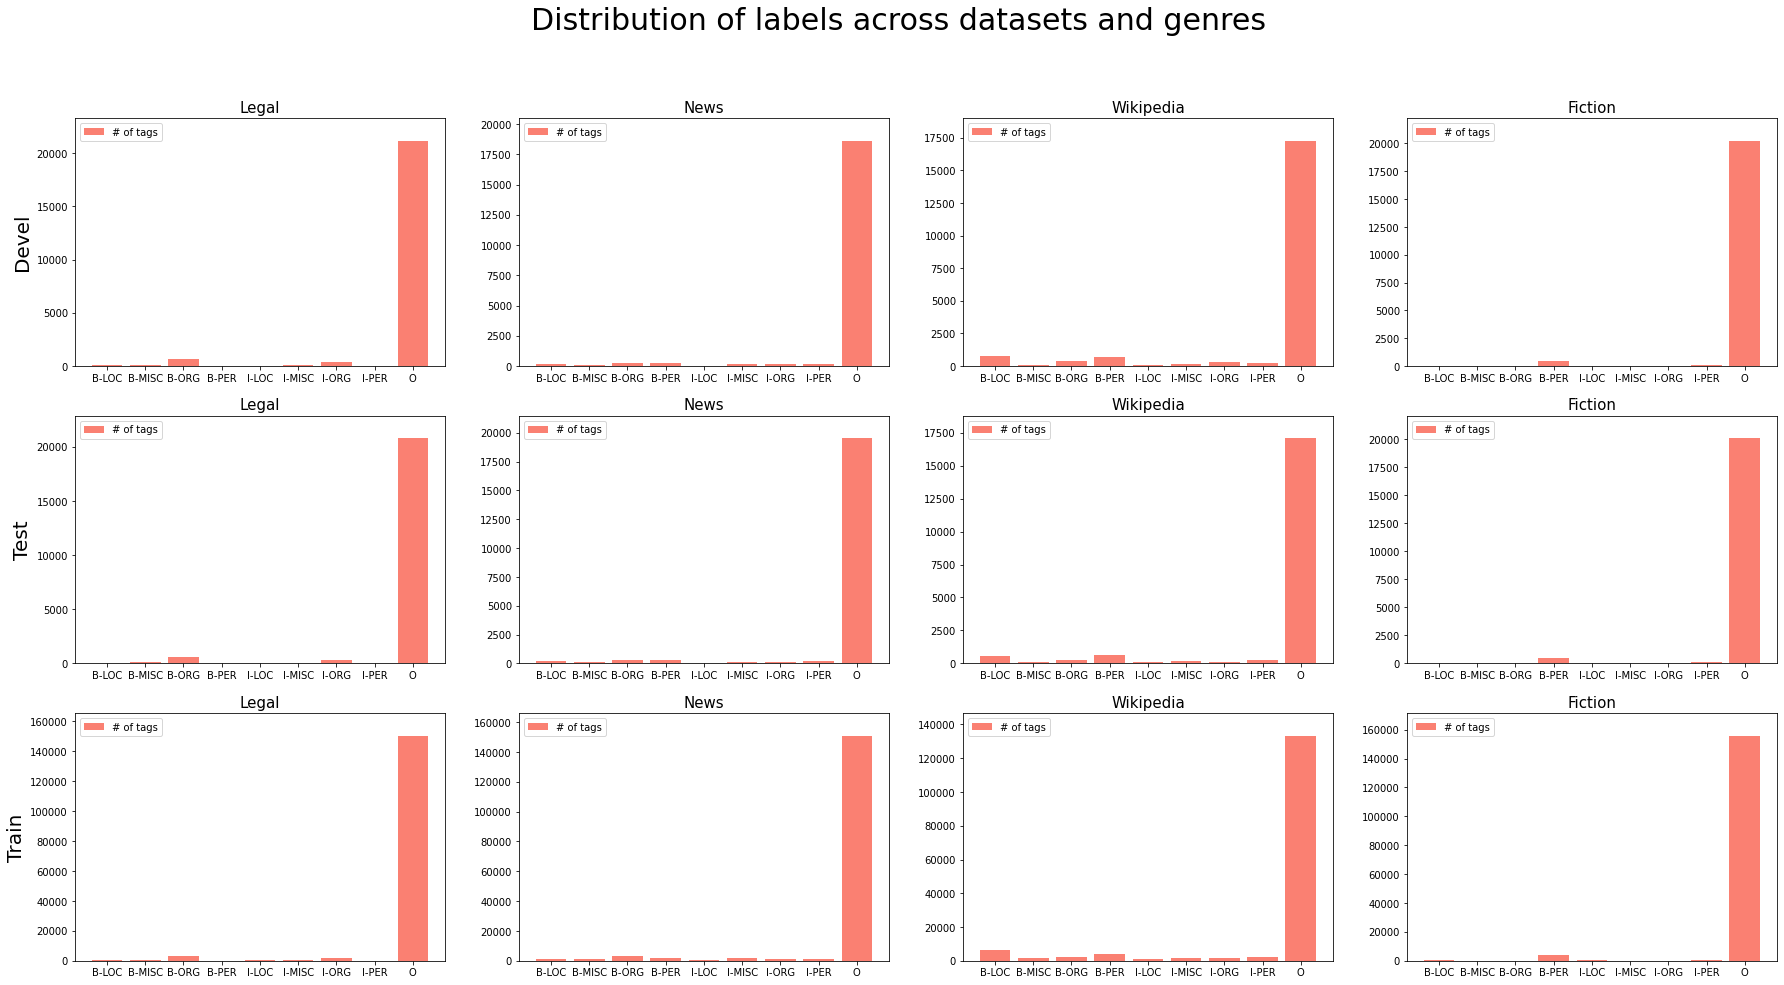

In [40]:
def plot_tag_distribution():
    data_dirs = get_train_devel_test_conllup_file_dirs()
    genres = [data_dirs[genre_dir] for genre_dir in data_dirs]
    fig, ax = plt.subplots(len(data_dirs),len(genres[0]))
    fig.suptitle("Distribution of labels across datasets and genres",  fontsize=30)
    fig.set_size_inches(30.5, 15.5)
    print(data_dirs)
    for i, dataset in enumerate(data_dirs):
        for j, genre_dir_path in enumerate(data_dirs[dataset]):
            genre = genre_dir_path.split(os.sep)[-2]
            df = load_csv_files_from_dir(genre_dir_path)
            value_counts = df["CONLL:NER"].value_counts().sort_index()
            rects = ax[i][j].bar(value_counts.keys(), value_counts.values, color="salmon", label="# of tags")
            ax[i][j].legend()
            if j == 0:
                ax[i][j].set_ylabel(f"{dataset[0].upper()}{dataset[1:]}").set_fontsize(20)
            ax[i][j].set_title(f"{genre[0].upper()}{genre[1:]}").set_fontsize(15)
            ax[i][j].set_ylim(0, max(value_counts.values) * 1.1)
        
plot_tag_distribution()
